Loading data from AVIAN_Influenza_beta_a_8.0e-09.csv

starting training...


Epoch  0
Estimated parameters:
r_a: 0.005289 (goal: 0.005000)
K_a: 88148.8 (goal: 50000.0)
mu_a: 0.00032541 (goal: 0.00034246)
delta_a: 0.0004351 (goal: 0.0004000)
Pi_h: 35.82 (goal: 30.00)
beta_h: 0.0000009210 (goal: 0.0000008000)
beta_a: 0.00000000800 (goal: 0.000000026)
mu_h: 0.00003952 (goal: 0.00003910)
delta_h: 0.078732 (goal: 0.077000)
b: 0.002175 (goal: 0.001000)
c: 0.01639 (goal: 0.01000)
gamma: 0.34643 (goal: 0.10000)
#################################

Epoch  1000
Estimated parameters:
r_a: 0.004302 (goal: 0.005000)
K_a: 78671.7 (goal: 50000.0)
mu_a: 0.00032798 (goal: 0.00034246)
delta_a: 0.0004374 (goal: 0.0004000)
Pi_h: 34.86 (goal: 30.00)
beta_h: 0.0000009170 (goal: 0.0000008000)
beta_a: 0.00000000759 (goal: 0.000000026)
mu_h: 0.00003976 (goal: 0.00003910)
delta_h: 0.079158 (goal: 0.077000)
b: 0.002179 (goal: 0.001000)
c: 0.01647 (goal: 0.01000)
gamma: 0.35091 (goal: 0.10000)
#####################

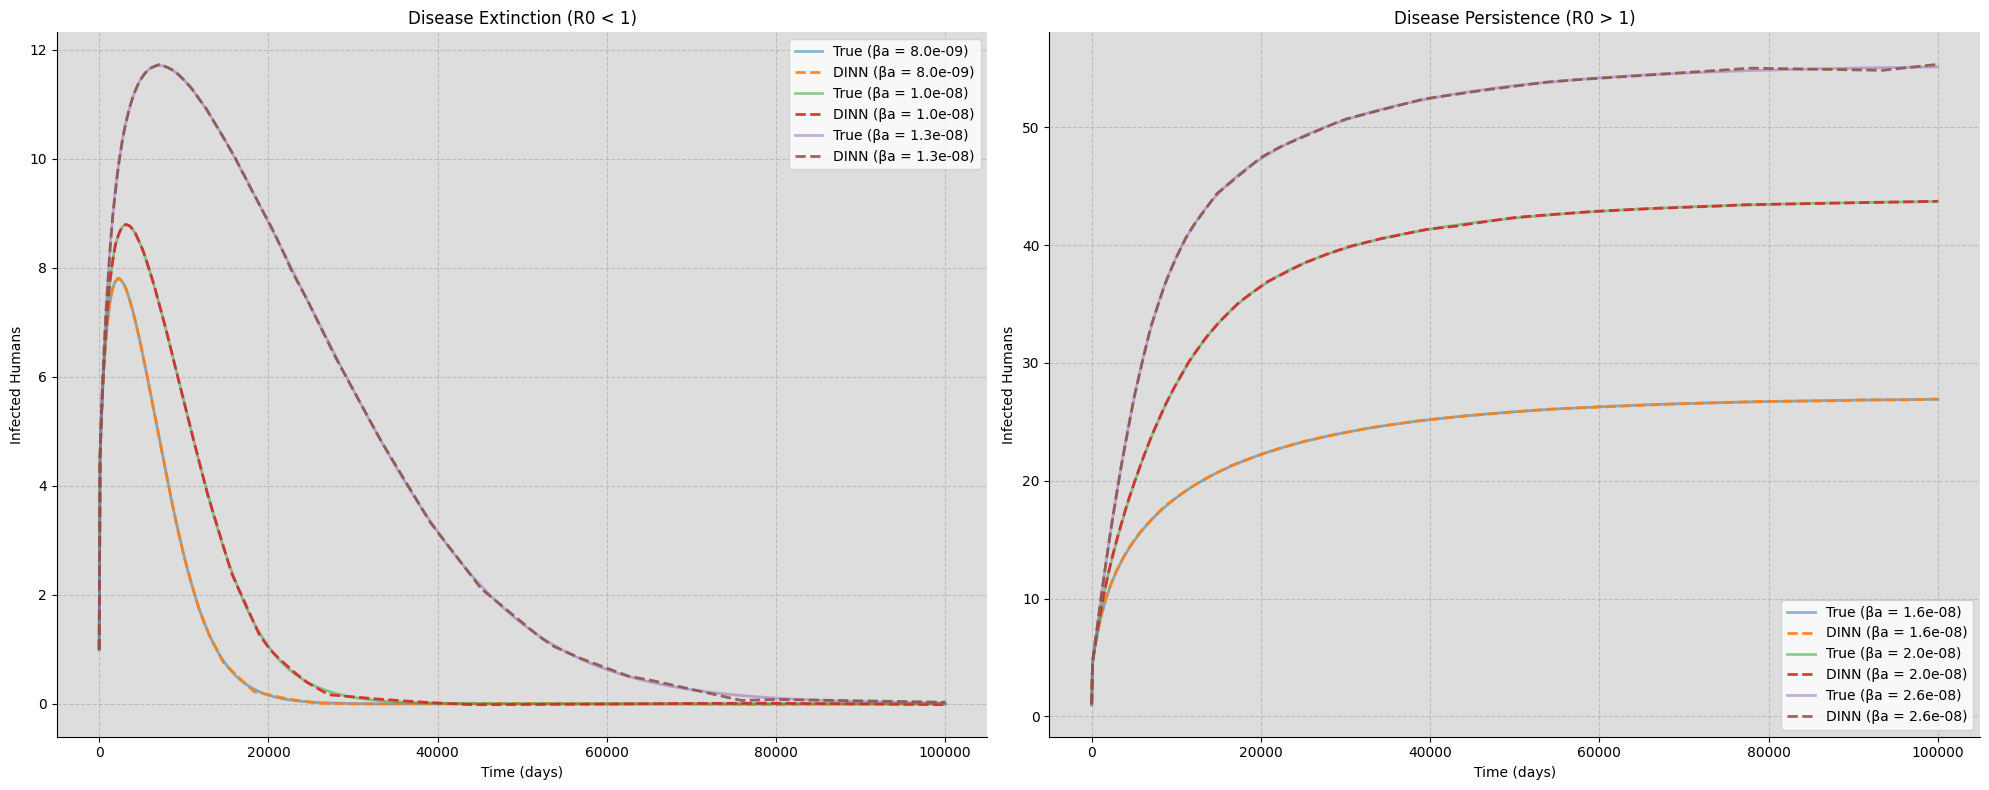

In [39]:
import numpy as np
from scipy import stats

class DINN(nn.Module):
    # def __init__(self, t, S_a_data, I_a_data, S_h_data, I_h_data, R_h_data):
        # super(DINN, self).__init__()
    def __init__(self, t, S_a_data, I_a_data, S_h_data, I_h_data, R_h_data, beta_a_init):
        super(DINN, self).__init__()
        
        self.epsilon = 1e-8
        
        # Convert input data to float32
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1))
        
        self.S_a = torch.tensor(S_a_data, dtype=torch.float32)
        self.I_a = torch.tensor(I_a_data, dtype=torch.float32)
        self.S_h = torch.tensor(S_h_data, dtype=torch.float32)
        self.I_h = torch.tensor(I_h_data, dtype=torch.float32)
        self.R_h = torch.tensor(R_h_data, dtype=torch.float32)

        self.losses = [] # here I saved the model's losses per epoch
        
        #setting the parameters
        self.r_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.K_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.delta_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.Pi_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        # self.beta_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_a_tilda = torch.nn.Parameter(torch.atanh((torch.tensor(beta_a_init) - 0.000000017) / 0.000000019), requires_grad=True)
        self.mu_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.delta_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #find values for normalization
        self.S_a_max = max(self.S_a)
        self.I_a_max = max(self.I_a)
        self.S_h_max = max(self.S_h)
        self.I_h_max = max(self.I_h)
        self.R_h_max = max(self.R_h)
        self.S_a_min = min(self.S_a)
        self.I_a_min = min(self.I_a)
        self.S_h_min = min(self.S_h)
        self.I_h_min = min(self.I_h)
        self.R_h_min = min(self.R_h)

        #normalize
        self.S_a_hat = (self.S_a - self.S_a_min) / (self.S_a_max - self.S_a_min + self.epsilon)
        self.I_a_hat = (self.I_a - self.I_a_min) / (self.I_a_max - self.I_a_min + self.epsilon)
        self.S_h_hat = (self.S_h - self.S_h_min) / (self.S_h_max - self.S_h_min + self.epsilon)
        self.I_h_hat = (self.I_h - self.I_h_min) / (self.I_h_max - self.I_h_min + self.epsilon)
        self.R_h_hat = (self.R_h - self.R_h_min) / (self.R_h_max - self.R_h_min + self.epsilon) 
        
        #matrices (x5 for S_a,I_a,S_h,I_h,R_h) for the gradients
        self.m1 = torch.zeros((len(self.t), 5)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 5)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 5)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 5)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 5)); self.m5[:, 4] = 1
        
        #NN
        self.net_si_sir = self.Net_si_sir()
        self.params = list(self.net_si_sir.parameters())
        self.params.extend(list([self.r_a_tilda, self.K_a_tilda, self.mu_a_tilda, self.delta_a_tilda, self.Pi_h_tilda, self.beta_h_tilda, self.beta_a_tilda, self.mu_h_tilda, self.delta_h_tilda, self.b_tilda, self.c_tilda, self.gamma_tilda]))
        
    #force parameters to be in the range of (-1, 1)

    @property
    def r_a(self):
        return torch.tanh(self.r_a_tilda) * 0.01 + 0.005  # Range: [0.0045, 0.0055]    

    @property
    def K_a(self):
        return torch.tanh(self.K_a_tilda) * 100000 + 50000  # Range: [0, 100000]    

    @property
    def mu_a(self):
        return torch.tanh(self.mu_a_tilda) * 0.0001 + 0.0003  # Range: [0.0002, 0.0004]    

    @property
    def delta_a(self):
        return torch.tanh(self.delta_a_tilda) * 0.0001 + 0.0004  # Range: [0.0003, 0.0005]    

    @property
    def Pi_h(self):
        return torch.tanh(self.Pi_h_tilda) * 100 + 30  # Range: [-70, 130]    

    @property
    def beta_h(self):
        return torch.tanh(self.beta_h_tilda) * 0.0000002 + 0.0000008  # Range: [0.0000006, 0.000001]    

    @property
    def beta_a(self):
        # Range to accommodate all beta_a values: [0.8e-8, 1.0e-8, 1.3e-8, 1.6e-8, 2.0e-8, 2.6e-8]
        return torch.tanh(self.beta_a_tilda) * 0.000000019 + 0.000000017  # Range: [0.8e-8, 2.6e-8]    

    @property
    def mu_h(self):
        return torch.tanh(self.mu_h_tilda) * 0.00001 + 0.000039  # Range: [0.000029, 0.000049]    

    @property
    def delta_h(self):
        return torch.tanh(self.delta_h_tilda) * 0.02 + 0.07  # Range: [0.05, 0.09]    

    @property
    def b(self):
        return torch.tanh(self.b_tilda) * 0.002 + 0.001  # Range: [-0.001, 0.003]    

    @property
    def c(self):
        return torch.tanh(self.c_tilda) * 0.02 + 0.01  # Range: [-0.01, 0.03]    

    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) * 0.3 + 0.15  # Range: [-0.15, 0.45]



    class Net_si_sir(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_si_sir, self).__init__()

            self.fc1=nn.Linear(1, 64) #takes 100 t's
            self.fc2=nn.Linear(64, 64)
            self.fc3=nn.Linear(64, 64)
            self.fc4=nn.Linear(64, 64)
            self.fc5=nn.Linear(64, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 64)
            self.fc8=nn.Linear(64, 64)
            self.fc9=nn.Linear(64, 64)
            self.fc10=nn.Linear(64,64)
            self.fc11=nn.Linear(64, 64)
            self.fc12=nn.Linear(64, 64)
            self.out=nn.Linear(64, 5) #outputs S_a, I_a, S_h, I_h, R_h (100 S_a, 100 I_a, 100 S_h, 100 I_h, 100 R_h --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            si_sir=F.relu(self.fc1(t_batch))
            si_sir=F.relu(self.fc2(si_sir))
            si_sir=F.relu(self.fc3(si_sir))
            si_sir=F.relu(self.fc4(si_sir))
            si_sir=F.relu(self.fc5(si_sir))
            si_sir=F.relu(self.fc6(si_sir))
            si_sir=F.relu(self.fc7(si_sir))
            si_sir=F.relu(self.fc8(si_sir))
            si_sir=F.relu(self.fc9(si_sir))
            si_sir=F.relu(self.fc10(si_sir))
            si_sir=F.relu(self.fc11(si_sir))
            si_sir=F.relu(self.fc12(si_sir))
            si_sir=self.out(si_sir)
            return si_sir
            
    def net_f(self, t_batch):
        
        #pass the timesteps batch to the neural network
        si_sir_hat = self.net_si_sir(t_batch)
        
        #organize S_a, I_a, S_h, I_h, R_h from the neural network's output -- note that these are normalized values -- hence the "hat" part
        S_a_hat, I_a_hat, S_h_hat, I_h_hat, R_h_hat = si_sir_hat[:,0], si_sir_hat[:,1], si_sir_hat[:,2], si_sir_hat[:,3], si_sir_hat[:,4]
        
        #S_a_t
        si_sir_hat.backward(self.m1, retain_graph=True)
        S_a_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_a_t
        si_sir_hat.backward(self.m2, retain_graph=True)
        I_a_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #S_h_t
        si_sir_hat.backward(self.m3, retain_graph=True)
        S_h_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_h_t
        si_sir_hat.backward(self.m4, retain_graph=True)
        I_h_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_h_t
        si_sir_hat.backward(self.m5, retain_graph=True)
        R_h_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S_a = self.S_a_min + (self.S_a_max - self.S_a_min) * S_a_hat
        I_a = self.I_a_min + (self.I_a_max - self.I_a_min) * I_a_hat
        S_h = self.S_h_min + (self.S_h_max - self.S_h_min) * S_h_hat      
        I_h = self.I_h_min + (self.I_h_max - self.I_h_min) * I_h_hat
        R_h = self.R_h_min + (self.R_h_max - self.R_h_min) * R_h_hat
        
        f1_hat = S_a_hat_t - (self.r_a * S_a * (1 - S_a / (self.K_a + self.epsilon)) - (self.beta_a * I_a * S_a) / (1 + self.b * I_a + self.epsilon)) / (self.S_a_max - self.S_a_min + self.epsilon)
        f2_hat = I_a_hat_t - ((self.beta_a * I_a * S_a) / (1 + self.b * I_a + self.epsilon) - (self.mu_a + self.delta_a) * I_a) / (self.I_a_max - self.I_a_min + self.epsilon)
        f3_hat = S_h_hat_t - (self.Pi_h - (self.beta_h * I_a * S_h) / (1 + self.c * I_h**2 + self.epsilon) - self.mu_h * S_h) / (self.S_h_max - self.S_h_min + self.epsilon)
        f4_hat = I_h_hat_t - ((self.beta_h * I_a * S_h) / (1 + self.c * I_h**2 + self.epsilon) - (self.mu_h + self.delta_h + self.gamma) * I_h) / (self.I_h_max - self.I_h_min + self.epsilon)
        f5_hat = R_h_hat_t - (self.gamma * I_h - self.mu_h * R_h) / (self.R_h_max - self.R_h_min + self.epsilon)
        
        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, S_a_hat, I_a_hat, S_h_hat, I_h_hat, R_h_hat

        
    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_a_pred_list = []
            I_a_pred_list = []
            S_h_pred_list = []
            I_h_pred_list = []
            R_h_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, f5, S_a_pred, I_a_pred, S_h_pred, I_h_pred, R_h_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, S_a_hat, I_a_hat, S_h_hat, I_h_hat, R_h_hat 
                
            self.optimizer.zero_grad() #zero grad
                
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_a_pred_list.append(self.S_a_min + (self.S_a_max - self.S_a_min) * S_a_pred)
            I_a_pred_list.append(self.I_a_min + (self.I_a_max - self.I_a_min) * I_a_pred)
            S_h_pred_list.append(self.S_h_min + (self.S_h_max - self.S_h_min) * S_h_pred)
            I_h_pred_list.append(self.I_h_min + (self.I_h_max - self.I_h_min) * I_h_pred)
            R_h_pred_list.append(self.R_h_min + (self.R_h_max - self.R_h_min) * R_h_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment

            loss = (torch.mean(torch.square(self.S_a_hat - S_a_pred)) + 
                    torch.mean(torch.square(self.I_a_hat - I_a_pred)) + 
                    torch.mean(torch.square(self.S_h_hat - S_h_pred)) + 
                    torch.mean(torch.square(self.I_h_hat - I_h_pred)) + 
                    torch.mean(torch.square(self.R_h_hat - R_h_pred)) + 
                    torch.mean(torch.square(f1)) + 
                    torch.mean(torch.square(f2)) + 
                    torch.mean(torch.square(f3)) + 
                    torch.mean(torch.square(f4)) + 
                    torch.mean(torch.square(f5))
                    ) 
            # Backpropagation and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())

            if epoch % 1000 == 0:          
                print('\nEpoch ', epoch)

                # print("Estimated parameters:")
                # print(f"r_a: {dinn.r_a.item():.6f} (goal: 0.005000)")
                # print(f"K_a: {dinn.K_a.item():.1f} (goal: 50000.0)")
                # print(f"mu_a: {dinn.mu_a.item():.8f} (goal: 0.00034246)")
                # print(f"delta_a: {dinn.delta_a.item():.7f} (goal: 0.0004000)")
                # print(f"Pi_h: {dinn.Pi_h.item():.2f} (goal: 30.00)")
                # print(f"beta_h: {dinn.beta_h.item():.10f} (goal: 0.0000008000)")
                # print(f"beta_a: {dinn.beta_a.item():.11f} (goal: 0.000000026)")
                # print(f"mu_h: {dinn.mu_h.item():.8f} (goal: 0.00003910)")
                # print(f"delta_h: {dinn.delta_h.item():.6f} (goal: 0.077000)")
                # print(f"b: {dinn.b.item():.6f} (goal: 0.001000)")
                # print(f"c: {dinn.c.item():.5f} (goal: 0.01000)")
                # print(f"gamma: {dinn.gamma.item():.5f} (goal: 0.10000)")

                # print('#################################') 
        # return S_a_pred_list, I_a_pred_list, S_h_pred_list, I_h_pred_list, R_h_pred_list

                print("Estimated parameters:")
                print(f"r_a: {self.r_a.item():.6f} (goal: 0.005000)")
                print(f"K_a: {self.K_a.item():.1f} (goal: 50000.0)")
                print(f"mu_a: {self.mu_a.item():.8f} (goal: 0.00034246)")
                print(f"delta_a: {self.delta_a.item():.7f} (goal: 0.0004000)")
                print(f"Pi_h: {self.Pi_h.item():.2f} (goal: 30.00)")
                print(f"beta_h: {self.beta_h.item():.10f} (goal: 0.0000008000)")
                print(f"beta_a: {self.beta_a.item():.11f} (goal: 0.000000026)")
                print(f"mu_h: {self.mu_h.item():.8f} (goal: 0.00003910)")
                print(f"delta_h: {self.delta_h.item():.6f} (goal: 0.077000)")
                print(f"b: {self.b.item():.6f} (goal: 0.001000)")
                print(f"c: {self.c.item():.5f} (goal: 0.01000)")
                print(f"gamma: {self.gamma.item():.5f} (goal: 0.10000)")    

                print('#################################') 

        return S_a_pred_list, I_a_pred_list, S_h_pred_list, I_h_pred_list, R_h_pred_list


import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def train_dinn_for_beta(beta_a_value):
    filename = f'AVIAN_Influenza_beta_a_{beta_a_value:.1e}.csv'
    print(f"Loading data from {filename}")
    avian_data = np.genfromtxt(filename, delimiter=',', skip_header=1).astype(np.float32)
    
    dinn = DINN(avian_data[:, 0], avian_data[:, 1], avian_data[:, 2], avian_data[:, 3], avian_data[:, 4], avian_data[:, 5], beta_a_value)
    
    optimizer = optim.Adam(dinn.params, lr=1e-4)
    dinn.optimizer = optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    dinn.scheduler = scheduler
    
    S_a_pred_list, I_a_pred_list, S_h_pred_list, I_h_pred_list, R_h_pred_list = dinn.train(50000)
    
    print(f"\nFinal parameters for beta_a = {beta_a_value:.1e}:")
    print(f"beta_a: {dinn.beta_a.item():.11f} (goal: {beta_a_value:.11f})")
    print("---")
    
    return avian_data, I_h_pred_list[0].detach().numpy()

# Define beta_a values
beta_a_values_1 = [0.8e-8, 1.0e-8, 1.3e-8]  # R0 < 1
beta_a_values_2 = [1.6e-8, 2.0e-8, 2.6e-8]  # R0 > 1

# Train DINN for each beta_a value
results_1 = [train_dinn_for_beta(beta_a) for beta_a in beta_a_values_1]
results_2 = [train_dinn_for_beta(beta_a) for beta_a in beta_a_values_2]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')

def plot_scenario(ax, beta_a_values, results, title):
    for beta_a, (data, prediction) in zip(beta_a_values, results):
        ax.plot(data[:, 0], data[:, 4], '-', alpha=0.5, lw=2, label=f'True (βa = {beta_a:.1e})')
        ax.plot(data[:, 0], prediction, '--', alpha=0.9, lw=2, label=f'DINN (βa = {beta_a:.1e})')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Infected Humans')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    ax.set_facecolor('#dddddd')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plot_scenario(ax1, beta_a_values_1, results_1, 'Disease Extinction (R0 < 1)')
plot_scenario(ax2, beta_a_values_2, results_2, 'Disease Persistence (R0 > 1)')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('DINN_results_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()